# Experiment 3: Random Forest (Baseline)

#####Train on LendingClub, Validate on GermanCredit & GiveMeSomeCredit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Step 0: Setup Environment
!pip install aif360 shap scikit-learn pandas matplotlib seaborn --quiet

# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import matplotlib.pyplot as plt

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric

RESULTS_DIR = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results _germanCredit &GivemesomeCredit'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 7.1 MB/s eta 0:00:00


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [ ]:
## Step 1: Load and Preprocess LendingClub Dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')

selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna()

# Convert target to binary
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Encode categoricals
for col in ['term','grade','home_ownership','purpose','zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Normalize income
df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])

/tmp/ipython-input-3739832076.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')


In [ ]:
## Step 2: Create AIF360 Dataset
privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])

In [ ]:
## Step 3: Train Random Forest Classifier
X = aif_data.features
y = aif_data.labels.ravel()

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

y_pred = clf.predict(X)
y_prob = clf.predict_proba(X)[:,1]

In [ ]:
## Step 4: Evaluate Performance and Fairness
print("=== LendingClub Training Performance ===")
print("Accuracy:", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1:", f1_score(y, y_pred))
print("AUC-ROC:", roc_auc_score(y, y_prob))

pred_dataset = aif_data.copy()
pred_dataset.labels = y_pred.reshape(-1,1)

metric = ClassificationMetric(aif_data, pred_dataset,
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print("SPD:", metric.statistical_parity_difference())
print("DI:", metric.disparate_impact())
print("EOD:", metric.equal_opportunity_difference())
print("AOD:", metric.average_odds_difference())
print("BiasAmp:", metric.between_group_generalized_entropy_index())
print("Theil:", metric.theil_index())

=== LendingClub Training Performance ===
Accuracy: 0.9994
Precision: 0.9997249724972497
Recall: 0.9994500962331592
F1: 0.9995875154681699
AUC-ROC: 0.9999986887841216
SPD: 0.42307692307692313
DI: 1.8461538461538463
EOD: 0.0
AOD: 0.0
BiasAmp: 166.16666666666666
Theil: 0.000477334337758019


In [ ]:
## Step 5: SHAP Explainability
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
X_df = pd.DataFrame(X, columns=aif_data.feature_names)
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_df)

In [ ]:
## Step 6: Validation on GermanCredit
GC_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/german_credit_data.csv'
df_gc = pd.read_csv(GC_PATH)

# Target
if 'Risk' in df_gc.columns:
    df_gc['loan_status'] = df_gc['Risk'].map({'good':1,'bad':0})
elif 'Creditability' in df_gc.columns:
    df_gc['loan_status'] = df_gc['Creditability']
elif 'class' in df_gc.columns:
    df_gc['loan_status'] = df_gc['class'].map({'good':1,'bad':0})

# Encode leftover strings
for col in df_gc.columns:
    if df_gc[col].dtype == 'object':
        df_gc[col] = LabelEncoder().fit_transform(df_gc[col].astype(str))

# Align schema
common_gc = pd.DataFrame()
common_gc['annual_inc']     = df_gc['Credit amount']
common_gc['term']           = df_gc['Duration']
common_gc['grade']          = df_gc['Purpose']
common_gc['home_ownership'] = df_gc['Housing']
common_gc['purpose']        = df_gc['Purpose']
common_gc['zip_code']       = df_gc['Checking account']
common_gc['loan_status']    = df_gc['loan_status']

for col in ['term','grade','home_ownership','purpose','zip_code']:
    common_gc[col] = LabelEncoder().fit_transform(common_gc[col].astype(str))
common_gc['annual_inc'] = StandardScaler().fit_transform(common_gc[['annual_inc']])

X_gc = common_gc.drop(columns=['loan_status']).values
y_gc = common_gc['loan_status'].values

y_pred_gc = clf.predict(X_gc)
y_prob_gc = clf.predict_proba(X_gc)[:,1]

print("\n=== GermanCredit Validation ===")
print("Accuracy:", accuracy_score(y_gc, y_pred_gc))
print("Precision:", precision_score(y_gc, y_pred_gc))
print("Recall:", recall_score(y_gc, y_pred_gc))
print("F1:", f1_score(y_gc, y_pred_gc))
print("AUC-ROC:", roc_auc_score(y_gc, y_prob_gc))




=== GermanCredit Validation ===
Accuracy: 0.458
Precision: 0.7257142857142858
Recall: 0.3628571428571429
F1: 0.4838095238095238
AUC-ROC: 0.5421095238095239


In [ ]:
## Step 7: Validation on GiveMeSomeCredit
GMSC_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/GiveMeSomeCredit.csv'
df_gmsc = pd.read_csv(GMSC_PATH)

df_gmsc['loan_status'] = 1 - df_gmsc['SeriousDlqin2yrs']

for col in df_gmsc.columns:
    if df_gmsc[col].dtype == 'object':
        df_gmsc[col] = LabelEncoder().fit_transform(df_gmsc[col].astype(str))

common_gmsc = pd.DataFrame()
common_gmsc['annual_inc']     = df_gmsc['MonthlyIncome'].fillna(df_gmsc['MonthlyIncome'].median())
common_gmsc['term']           = df_gmsc['NumberOfOpenCreditLinesAndLoans']
common_gmsc['grade']          = df_gmsc['NumberOfTimes90DaysLate']
common_gmsc['home_ownership'] = df_gmsc['NumberRealEstateLoansOrLines']
common_gmsc['purpose']        = df_gmsc['NumberOfTime30-59DaysPastDueNotWorse']
common_gmsc['zip_code']       = df_gmsc['NumberOfDependents'].fillna(0)
common_gmsc['loan_status']    = df_gmsc['loan_status']

for col in ['term','grade','home_ownership','purpose','zip_code']:
    common_gmsc[col] = LabelEncoder().fit_transform(common_gmsc[col].astype(str))
common_gmsc['annual_inc'] = StandardScaler().fit_transform(common_gmsc[['annual_inc']])

X_gmsc = common_gmsc.drop(columns=['loan_status']).values
y_gmsc = common_gmsc['loan_status'].values

y_pred_gmsc = clf.predict(X_gmsc)
y_prob_gmsc = clf.predict_proba(X_gmsc)[:,1]

print("\n=== GiveMeSomeCredit Validation ===")
print("Accuracy:", accuracy_score(y_gmsc, y_pred_gmsc))
print("Precision:", precision_score(y_gmsc, y_pred_gmsc))
print("Recall:", recall_score(y_gmsc, y_pred_gmsc))
print("F1:", f1_score(y_gmsc, y_pred_gmsc))
print("AUC-ROC:", roc_auc_score(y_gmsc, y_prob_gmsc))




=== GiveMeSomeCredit Validation ===
Accuracy: 0.33918
Precision: 0.9144196238358999
Recall: 0.3219812250846586
F1: 0.47626293848177914
AUC-ROC: 0.3959499676938379


In [ ]:
## Step 8: Save Combined Results
results_all = pd.DataFrame([
    {'Dataset':'LendingClub','Accuracy':accuracy_score(y,y_pred),'Precision':precision_score(y,y_pred),
     'Recall':recall_score(y,y_pred),'F1':f1_score(y,y_pred),'AUC':roc_auc_score(y,y_prob)},
    {'Dataset':'GermanCredit','Accuracy':accuracy_score(y_gc,y_pred_gc),'Precision':precision_score(y_gc,y_pred_gc),
     'Recall':recall_score(y_gc,y_pred_gc),'F1':f1_score(y_gc,y_pred_gc),'AUC':roc_auc_score(y_gc,y_prob_gc)},
    {'Dataset':'GiveMeSomeCredit','Accuracy':accuracy_score(y_gmsc,y_pred_gmsc),'Precision':precision_score(y_gmsc,y_pred_gmsc),
     'Recall':recall_score(y_gmsc,y_pred_gmsc),'F1':f1_score(y_gmsc,y_pred_gmsc),'AUC':roc_auc_score(y_gmsc,y_prob_gmsc)}
])

results_all

,Dataset,Accuracy,Precision,Recall,F1,AUC
0,LendingClub,0.99940,0.999725,0.999450,0.999588,0.999999
1,GermanCredit,0.45800,0.725714,0.362857,0.483810,0.542110
2,GiveMeSomeCredit,0.33918,0.914420,0.321981,0.476263,0.395950


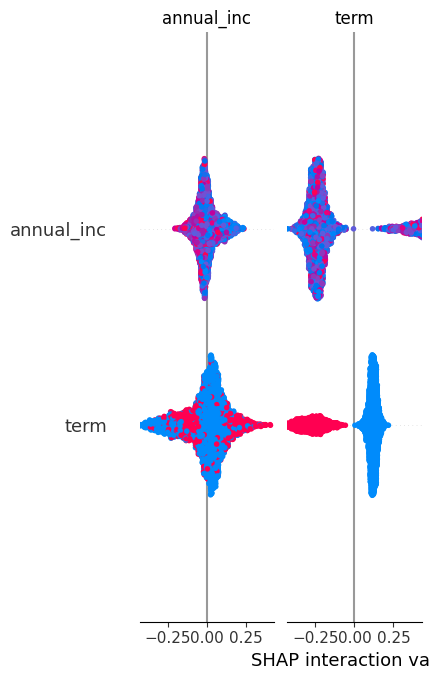

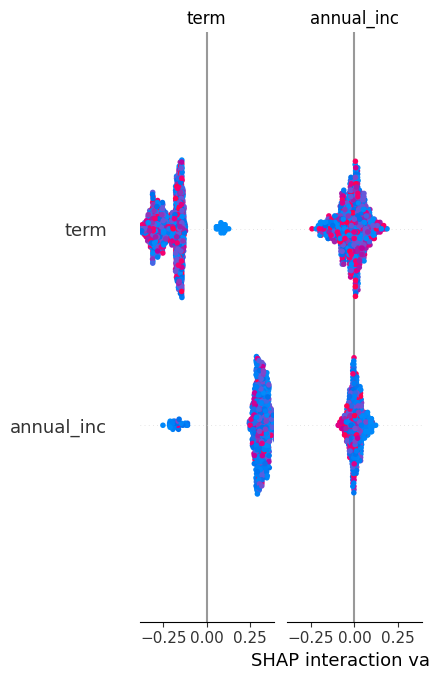

In [ ]:
# --- LendingClub SHAP ---
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

X_df = pd.DataFrame(X, columns=aif_data.feature_names)
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_df)
else:
    shap.summary_plot(shap_values, X_df)

# --- GermanCredit SHAP ---
explainer_gc = shap.TreeExplainer(clf)
shap_values_gc = explainer_gc.shap_values(X_gc)

X_gc_df = pd.DataFrame(X_gc, columns=['annual_inc','term','grade','home_ownership','purpose','zip_code'])
if isinstance(shap_values_gc, list):
    shap.summary_plot(shap_values_gc[1], X_gc_df)
else:
    shap.summary_plot(shap_values_gc, X_gc_df)

# --- GiveMeSomeCredit SHAP ---
explainer_gmsc = shap.TreeExplainer(clf)
shap_values_gmsc = explainer_gmsc.shap_values(X_gmsc)

X_gmsc_df = pd.DataFrame(X_gmsc, columns=['annual_inc','term','grade','home_ownership','purpose','zip_code'])
if isinstance(shap_values_gmsc, list):
    shap.summary_plot(shap_values_gmsc[1], X_gmsc_df)
else:
    shap.summary_plot(shap_values_gmsc, X_gmsc_df)

In [ ]:
## Step 8: Save Combined Results

results_all = pd.DataFrame([
    {
        'Dataset':'LendingClub',
        'Accuracy':accuracy_score(y,y_pred),
        'Precision':precision_score(y,y_pred),
        'Recall':recall_score(y,y_pred),
        'F1':f1_score(y,y_pred),
        'AUC':roc_auc_score(y,y_prob)
    },
    {
        'Dataset':'GermanCredit',
        'Accuracy':accuracy_score(y_gc,y_pred_gc),
        'Precision':precision_score(y_gc,y_pred_gc),
        'Recall':recall_score(y_gc,y_pred_gc),
        'F1':f1_score(y_gc,y_pred_gc),
        'AUC':roc_auc_score(y_gc,y_prob_gc)
    },
    {
        'Dataset':'GiveMeSomeCredit',
        'Accuracy':accuracy_score(y_gmsc,y_pred_gmsc),
        'Precision':precision_score(y_gmsc,y_pred_gmsc),
        'Recall':recall_score(y_gmsc,y_pred_gmsc),
        'F1':f1_score(y_gmsc,y_pred_gmsc),
        'AUC':roc_auc_score(y_gmsc,y_prob_gmsc)
    }
])

# Save to CSV in your RESULTS_DIR
results_all.to_csv(f"{RESULTS_DIR}/exp3_rf_validation_results.csv", index=False)

print(f"Validation results saved to {RESULTS_DIR}/exp3_rf_validation_results.csv")